### Overview:
This notebook provides an example of how we can query a new geneset (e.g., output of a differential expresion analysis) against PAC. First, we load PAC and associated metadata. We then perform a differential expression analysis for different types of breast cancer. Finally, we show how the resulting set of genes may be used as a query in the PAC method. 

Note: although this notebook was developed for a specific example, you can go to the "QUERY A GENE SET" section towards the end and replace the query with any other gene set query of interest (see below).

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.multitest as multitest
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import networkx as nx

import matplotlib as mpl

rainbow_cmap = mpl.cm.get_cmap("rainbow")

import sys
import utils_query_new_genesets as query_functions
import plotly.express as px 

import copy
import importlib
importlib.reload(query_functions)

import plotly.graph_objects as go

import textwrap

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


## Load pathway tool and relevant annotations:

In [2]:
acronym_to_folder = {"KEGG": "c2.all.v7.0.symbols_JustK", "REACTOME":"c2.all.v7.0.symbols_JustR",
                  "GO_BP": "c5.bp.v7.0.symbols_SHORT", "GO_CC": "c5.cc.v7.0.symbols", "GO_MF": "c5.mf.v7.0.symbols"}
folder_to_acronym = query_functions.reverse_dict(acronym_to_folder, assume_unique = True)
pway_subfolders =  'c2.all.v7.0.symbols_JustK-c2.all.v7.0.symbols_JustR-c5.bp.v7.0.symbols_SHORT-c5.mf.v7.0.symbols'
gsets_folders = pway_subfolders.split("-")
gsets_acronyms = [folder_to_acronym[x] for x in gsets_folders]

path_to_adj_matrices = '../../pipeline/adj_matrices/'
path_to_pways = "../../pathways_raw/"

pathways_df, all_genes = query_functions.load_pathway_df_genes(gsets_folders, path_to_pways)
pathway_names, G_with_weights = query_functions.load_pathways_G_with_weights(path_to_adj_matrices, gsets_folders, pathways_df)


new_com_df = pd.read_csv("../../pipeline/Full_graph_louvain_with_weights_community_labels/0.4/labels.tsv", delimiter="\t", names=["pathways", "com"])
new_com_df = new_com_df.merge(pd.DataFrame(pathway_names.reshape(len(pathway_names),1), columns=["pathways"]), how="right", on="pathways")
coms = new_com_df["com"].values
num_coms = len(np.unique(coms))

colors = [rainbow_cmap(com_idx/len(np.unique(coms))) for com_idx in range(len(coms))]

colors_list = [rainbow_cmap(x/len(np.unique(coms))) for x in np.unique(coms)]
C_colormap = {"C%i"%(int(i+1)):mpl.colors.to_hex(colors_list[i]) for i in range(len(np.unique(coms)))}

c2.all.v7.0.symbols_JustK
c2.all.v7.0.symbols_JustR
c5.bp.v7.0.symbols_SHORT
c5.mf.v7.0.symbols


/homes/gws/nbbwang/pathway_communities_public/pipeline/combined_graph_analyses/utils_query_new_genesets.py:59: RuntimeWarning: divide by zero encountered in log10
  weights =  -1 * np.log10(pvals)


In [3]:
sig_com_genes_df = pd.read_csv('appendix_tables/significantly_overrepresented_genes.csv')
kmers_df_query_coms = pd.read_csv("appendix_tables/all_kmers.csv")

### Code for generating plots

In [4]:

def get_top_kmers(x, top_n):
    return kmers_df_query_coms[kmers_df_query_coms["community"]==x].sort_values(["k", "count", "hubness"], ascending=[False, False, False])["kmer"].values[:top_n]

def get_plot_data(query_dqs, query_gws, geneset):
    mod_change_df = pd.DataFrame(np.vstack([np.unique(coms)+1,query_dqs]).T, columns=["com", "modularity change"])
    mod_change_df["Community"]=mod_change_df["com"].apply(lambda x: "C%i"%(int(x)))
    mod_change_df = mod_change_df.sort_values("modularity change", ascending=False)
    mod_change_df["K-Mers"] = mod_change_df["com"].apply(lambda x: "<br>".join(get_top_kmers(x, 10)))

    toplot_data = copy.copy(new_com_df)
    toplot_data["com"] += 1
    toplot_data["edge_weights"] = query_gws
    toplot_data["query_genes_in_pway"] = pathways_df["genes"].apply(lambda x: np.intersect1d(x, geneset))
    toplot_data["color_for_com"] = toplot_data["com"].apply(lambda x: colors_list[x-1])
    toplot_data["Community"] = toplot_data["com"].apply(lambda x: "C%i"%x) 
    toplot_data["sorted_com_order"] = toplot_data["com"].apply(lambda x: (np.argsort(mod_change_df.index))[x-1])
    return mod_change_df, toplot_data

def static_enrichment_bar_plot(toplot_data, top_n):

    top_pathways = pathway_names[np.argsort(toplot_data["edge_weights"].values)[::-1][:top_n]]
    static_enrichment_df = toplot_data[np.in1d(toplot_data["pathways"], top_pathways)].sort_values("edge_weights", ascending=False)

    fig = plt.figure(figsize=(10,len(static_enrichment_df)/3))

    ax=sns.barplot(x="edge_weights", y="pathways", data=static_enrichment_df, palette=static_enrichment_df["color_for_com"], dodge=False, saturation=1, orient="horizontal")
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('None')
    
    plt.show()
    
    return ax

def interactive_mod_change_bar_plot(mod_change_df):
    
    hover_data_display={'Community':True, 'modularity change':':.2e', 'K-Mers':True} 
                        
    fig1 = px.bar(
        data_frame=mod_change_df,
        x='Community',
        y='modularity change',
        hover_data=hover_data_display,
        template='plotly_white',
        color='Community',
        color_discrete_map =C_colormap
    )
    fig1.update_layout(showlegend=False)
    fig1.update_layout(height=300)
    return fig1



def interactive_enrichment_strip_plot(toplot_data, top_n, plot_threshold=0):
    hover_data_display={'com':False, 'edge_weights':':.2f', 'color_for_com':False, 'sorted_com_order':False, 
                        "pathways":True, "query_genes_in_pway":True}

    fig2 = px.strip(data_frame=toplot_data[toplot_data["edge_weights"]>=plot_threshold],  y="edge_weights", x="sorted_com_order", color="Community", 
                   hover_data=hover_data_display,template='plotly_white',
                   color_discrete_map = C_colormap)
    fig2.update_layout(showlegend=False)
    fig2.update_layout(height=500)
    fig2.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = toplot_data["sorted_com_order"].values,
            ticktext = toplot_data["com"].values)
    )
    
    y_cutoff = toplot_data.sort_values("edge_weights", ascending=False)[:top_n]["edge_weights"].values[-1]
    fig2.add_trace(go.Scatter(x=[0,toplot_data["com"].max()-1], y=[y_cutoff,y_cutoff],
                    mode='lines',
                    name='lines', line=dict(color='rgba(100, 100, 100, 0.5)', width=3)))
    fig2.update_yaxes(rangemode="tozero")


    return fig2

    
def normalize_width(x, maxweight, minweight, maxwidth, minwidth):
    normed_val = (x - minweight)/(maxweight-minweight)
    normed_width = (maxwidth-minwidth) * normed_val + minwidth
    return normed_width


def update_network_graph(toplot_data, max_nodes,  barchart_order=None, maxwidth = 5, minwidth = .1, maxnodesize = 30, minnodesize = 10, spring_k=None):

    to_plot_df_nodes = toplot_data[toplot_data["edge_weights"]>-np.log10(.05)].sort_values("edge_weights", ascending=False)[:max_nodes].index
    
    sig_thresh_in_graph = 10**(-(toplot_data.loc[to_plot_df_nodes[-1]]["edge_weights"]))
    nodes_shown = len(to_plot_df_nodes)
    
    G = G_with_weights.subgraph(to_plot_df_nodes)


    #Filter out low-weight edges
    edges =  nx.to_numpy_matrix(G, nodelist= G.nodes())
    edges[edges<4] = 0
    edge_df = pd.DataFrame(edges, index=G.nodes, columns=G.nodes)
    #Save the modified graph
    G = nx.from_pandas_adjacency(edge_df)

    pos = nx.layout.spring_layout(G, spring_k)

    maxweight = max(dict(G.edges).items(), key=lambda x: x[1]['weight'])[1]["weight"]
    minweight = min(dict(G.edges).items(), key=lambda x: x[1]['weight'])[1]["weight"]

    query_enrichment_nlog10pvals = toplot_data.iloc[list(G.nodes())]["edge_weights"].values    
    minenriched = np.min(query_enrichment_nlog10pvals)
    maxenriced = np.max(query_enrichment_nlog10pvals)


    for n, p in pos.items():
        G.nodes[n]['pos'] = p

    edge_traces = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x = []
        edge_y = []
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weight = G[edge[0]][edge[1]]['weight']
        edge_traces.append(go.Scatter(x=edge_x, y=edge_y,
                    line=dict(width=normalize_width(weight, maxweight, minweight, maxwidth, minwidth), 
                              color='rgba(150, 150, 150, 0.3)'),
                    mode='lines'))


    node_x = []
    node_y = []
    node_colors = []
    node_text = []
    node_label = []
    for i,node in enumerate(G.nodes()):
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_colors.append(C_colormap["C%i"%(coms[node]+1)])

        if len(np.where(np.in1d(pathway_names[node], barchart_order))[0])>0:
            node_text.append("%i"%(np.where(np.in1d(barchart_order,pathway_names[node]))[0][0]+1))
        else:
            node_text.append("")


        node_label.append(pathway_names[node])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        hovertext=node_label,
        text=node_text,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            size=10,
            line_width=1),
        textfont=dict(
            family="arial",
            size=16,
            color="black"))



    node_communities = [coms[i] for i in G.nodes]
    node_trace.marker.color = node_communities
    node_trace.marker.color = [C_colormap["C%i"%(coms[i]+1)] for i in G.nodes]
    node_trace.marker.size = [normalize_width(x, maxenriced, minenriched, maxnodesize, minnodesize) for x in query_enrichment_nlog10pvals]

    fig = go.Figure(data=edge_traces + [node_trace],
                 layout=go.Layout(
                    title='Title text',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Showing the top %s enriched pathways (enrichment p-values of %f and lower)"%(nodes_shown,sig_thresh_in_graph),
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                    )
    fig.update_layout(plot_bgcolor='white')

    return fig, nodes_shown, sig_thresh_in_graph 


# BASIC DIFFERENTIAL GENE EXPRESSION ANALYSIS WITH METABRIC

In this analysis, we load the METABRIC data set, do differential gene expression analysis to compare patients in different conditions (e.g., positive vs negative ER Status) 

In [5]:
path_to_metabric = "../../Datasets/METABRIC/"


In [6]:
METABRIC_data_clinical_patient_INFO = pd.read_csv(path_to_metabric + "data_clinical_patient.txt", sep='\t', nrows=4)
METABRIC_data_clinical_patient = pd.read_csv(path_to_metabric + "data_clinical_patient.txt", sep='\t', skiprows=4)

METABRIC_data_clinical_sample_INFO = pd.read_csv(path_to_metabric + "data_clinical_sample.txt", sep='\t', nrows=4)
METABRIC_data_clinical_sample = pd.read_csv(path_to_metabric + "data_clinical_sample.txt", sep='\t', skiprows=4)

METABRIC_data_mRNA_median_Zscores = pd.read_csv(path_to_metabric + "data_mRNA_median_Zscores.txt", sep='\t')

In [7]:
METABRIC_vars = METABRIC_data_clinical_sample.merge(METABRIC_data_clinical_patient, on="PATIENT_ID")
binary_vars = [x for x in METABRIC_vars.columns if len(METABRIC_vars[x].value_counts())==2]

vars_of_interest = ["ER_STATUS", "HER2_STATUS", "PR_STATUS"]

In [8]:
group_gene_differences_pvals_bcorrected = {}
group_gene_differences_tscores = {}
group_gene_differences_avg_exp_outcome1 = {}
group_gene_differences_avg_exp_outcome2 = {}

for var in vars_of_interest:
    [outcome1,outcome2], [outcome1_count, outcome2_count] = np.unique(METABRIC_vars[var].dropna(), return_counts=True)
    print("%s: %s (%i), %s (%i)"%(var, outcome1, outcome1_count, outcome2, outcome2_count))
    
    #ignore variables where there are not enough examples of some class
    if min(outcome1_count, outcome2_count) < 100:
        continue
    
    # GET SAMPLES FOR EACH GROUP
    rows_outcome1 = METABRIC_vars[METABRIC_vars[var]==outcome1]
    samples_outcome1 = np.intersect1d(rows_outcome1["PATIENT_ID"].values, METABRIC_data_mRNA_median_Zscores.columns)

    rows_outcome2 = METABRIC_vars[METABRIC_vars[var]==outcome2]
    samples_outcome2 = np.intersect1d(rows_outcome2["PATIENT_ID"].values, METABRIC_data_mRNA_median_Zscores.columns)
    
    
    GE_outcome1 = METABRIC_data_mRNA_median_Zscores[samples_outcome1].values
    GE_outcome2 = METABRIC_data_mRNA_median_Zscores[samples_outcome2].values

    group_gene_differences_avg_exp_outcome1[var] = np.nanmean(GE_outcome1, axis=1)
    group_gene_differences_avg_exp_outcome2[var] = np.nanmean(GE_outcome2, axis=1)

    t_test_stats = []
    t_test_pvals = []

    for i in range(len(METABRIC_data_mRNA_median_Zscores)):
        t,p = stats.ttest_ind(GE_outcome1[i], GE_outcome2[i], nan_policy="omit")
        t_test_stats.append(t)
        t_test_pvals.append(p)

    t_test_pvals_bonf_corrected = np.array(t_test_pvals) * len(METABRIC_data_mRNA_median_Zscores)
    group_gene_differences_pvals_bcorrected[var] = t_test_pvals_bonf_corrected    
    group_gene_differences_tscores[var] = np.array(t_test_stats)

ER_STATUS: Negative (644), Positive (1825)
HER2_STATUS: Negative (1733), Positive (247)
PR_STATUS: Negative (940), Positive (1040)


In [9]:
# set limit of top 1% of genes
top_num = int(np.floor(len(METABRIC_data_mRNA_median_Zscores) * .01))

In [10]:
# for key in group_gene_differences_pvals_bcorrected.keys():
SIG_GENES_TOP = {}
results_dfs = {}
for key in vars_of_interest:

    corrected_pvals = group_gene_differences_pvals_bcorrected[key]
    
    results_df = copy.deepcopy(METABRIC_data_mRNA_median_Zscores[["Hugo_Symbol"]])
    results_df["corrected_pval"] = group_gene_differences_pvals_bcorrected[key]
    results_df["t_stat"] = group_gene_differences_tscores[key]
    results_df["outcome1avg"] = group_gene_differences_avg_exp_outcome1[key]
    results_df["outcome2avg"] = group_gene_differences_avg_exp_outcome2[key]
    results_dfs[key] = results_df
    
    SIG_GENES = results_df[results_df["corrected_pval"]<.01].sort_values("corrected_pval")["Hugo_Symbol"].values
    SIG_GENES_TOP[key] = SIG_GENES[:top_num]
    
    print(key, len(SIG_GENES), len(SIG_GENES_TOP[key]))


ER_STATUS 8605 243
HER2_STATUS 3243 243
PR_STATUS 6457 243


#### Generate example file for "query multiple gene sets" page of website:

In [11]:
f = open("example_queries.csv", "a")

for key in SIG_GENES_TOP.keys():
    f.write("%s, "%key)
    f.write(", ".join(SIG_GENES_TOP[key]))
    f.write("\n")
f.close()


In [27]:
SIG_GENES_TOP

{'ER_STATUS': array(['AGR3', 'ESR1', 'CA12', 'GATA3', 'PSAT1', 'TBC1D9', 'FOXA1',
        'DNALI1', 'MLPH', 'MYB', 'MAPT', 'U79293', 'RERG', 'TFF3',
        'PPP1R14C', 'IL6ST', 'AFF3', 'C9orf116', 'XBP1', 'C6orf97',
        'SUSD3', 'GFRA1', 'VGLL1', 'GAMT', 'DEGS2', 'SOX11', 'SLC39A6',
        'NME3', 'KLHDC9', 'NAT1', 'SCUBE2', 'TTLL4', 'DNAJC12', 'ANXA9',
        'ARSG', 'BX109404', 'SKP1', 'FBP1', 'CCNE1', 'CMBL', 'P4HTM',
        'BCL11A', 'CDCA7', 'PDSS1', 'C16orf57', 'BCL2', 'HAPLN3',
        'C5orf30', 'C1orf106', 'MPP6', 'IGF1R', 'CXXC5', 'RABEP1', 'LPIN1',
        'EVL', 'CASC1', 'TFF1', 'DACH1', 'SLC7A8', 'LRP8', 'DYNLRB2',
        'RSPH1', 'C1orf64', 'FAM123B', 'MAGED2', 'RAB17', 'TCEAL3',
        'CCDC24', 'PRKX', 'SYBU', 'DSC2', 'WWP1', 'TCTN1', 'CHCHD5',
        'EML4', 'UBASH3B', 'CIRBP', 'SLC44A4', 'SKP2', 'NUP93', 'KRT16P3',
        'RUNDC1', 'GSDMC', 'AGR2', 'SYTL4', 'PFKP', 'FAM171A1', 'SLC22A5',
        'PLEKHG1', 'CLSTN2', 'INPP5J', 'C11orf75', 'SCCPDH', 'WFS1',


### Supplementary figure showing which communities of pathways genes are in

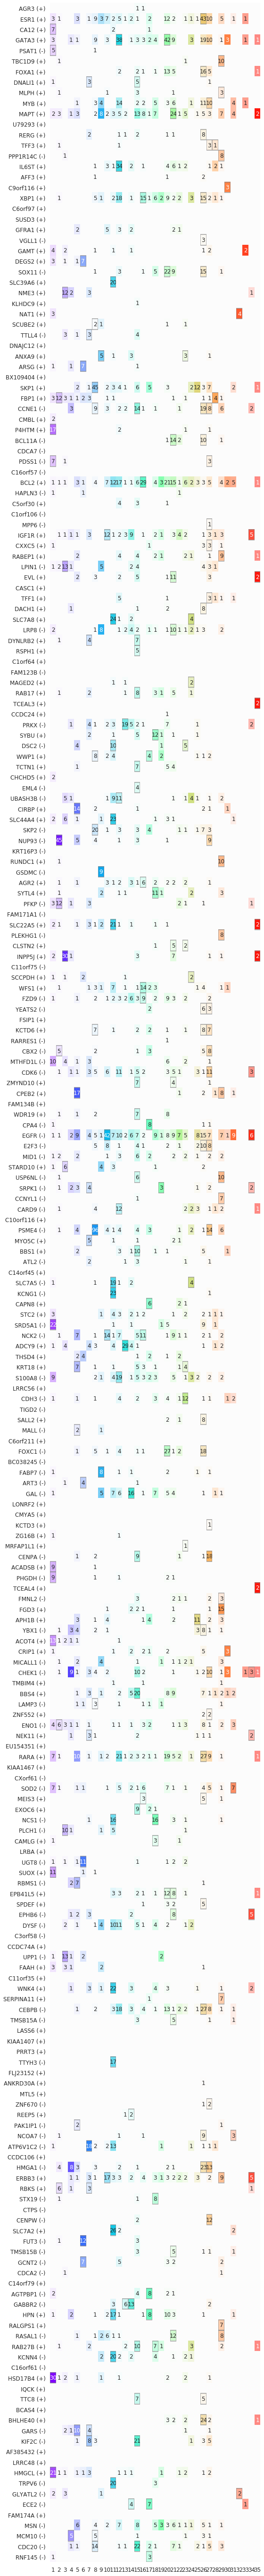

In [33]:
results_df = results_dfs["ER_STATUS"]
all_pways_w_gene = []
sig_overrepresented = []
genes_sorted_label = []
for i,row in results_df[results_df["corrected_pval"]<.01].sort_values("corrected_pval").iloc[:top_num].iterrows():
    gene = row["Hugo_Symbol"]
    coms_overrepresented = sig_com_genes_df[sig_com_genes_df["gene"]==gene].sort_values("pval_corrected")["com"].values.astype(int)

    if row["outcome1avg"] > row["outcome2avg"]:
        sign = "-"
    else:
        sign = "+"
    genes_sorted_label.append("%s (%s)"%(gene, sign))
        
        
    pways_w_gene = pathways_df["names"].iloc[np.where(pathways_df["genes"].apply(lambda x: gene in x))[0]]
    pways_coms_w_gene = pd.DataFrame(pways_w_gene).merge(new_com_df, left_on="names", right_on="pathways")["com"]
    
    tmp = np.zeros(len(np.unique(coms)))
    if len(pways_w_gene)>0:
        coms_tmp, counts = np.unique(pways_coms_w_gene, return_counts=True)
        tmp[coms_tmp] = counts

    all_pways_w_gene.append(tmp)
    sig_overrepresented.append(coms_overrepresented)
    
df_to_plot = pd.DataFrame(all_pways_w_gene, columns=np.arange(len(np.unique(coms)))+1, index=genes_sorted_label, dtype=int)
cm_communities = []
for i,tmp_color in enumerate(C_colormap.values()):
    cm_communities.append(mcolors.LinearSegmentedColormap.from_list('CustomMap', [(.99,.99,.99),tmp_color]))


f, axs = plt.subplots(1, df_to_plot.columns.size, gridspec_kw={'wspace': 0}, figsize=(8,100))
for i, (s, a, c) in enumerate(zip(df_to_plot.columns, axs, cm_communities)):
    tmp_toplot = np.array([df_to_plot[s].values.astype(int)]).T
    tmp_annot = np.array([[str(x[0])] if x>0 else [""] for x in tmp_toplot])
    sns.set(font_scale=1.4)
    g = sns.heatmap(tmp_toplot, yticklabels=df_to_plot.index, xticklabels=[s],
                annot=tmp_annot, fmt='s', ax=a, cmap=c, cbar=False, annot_kws={"fontsize":12})
    a.set_xticklabels(a.get_xmajorticklabels(), fontsize = 12)



    gene_idx_w_sig_overrepresentation = np.where([i+1 in x for x in sig_overrepresented])[0]
    for elt in gene_idx_w_sig_overrepresentation:
        a.add_patch(Rectangle((0, elt), 1,1, fill=False, edgecolor="#888888", lw=1.5, alpha=.8))

    
    if i>0:
        a.yaxis.set_ticks([])
    else:
        a.set_yticklabels(a.get_ymajorticklabels(), fontsize = 12)



# QUERY A GENE SET:
In this example, we use top differentially genes between ER+ and ER- cancers, as computed above. However, you can also replace these genes with ones from your own analysis - simply re-define "query_genes" with your query array of genes.

In [34]:
query_genes = SIG_GENES_TOP["ER_STATUS"]

### Generating interactive query results:

In [ ]:
query_gws, query_dqs = query_functions.query_modularities(pathways_df, G_with_weights, all_genes, coms, query_genes)
mod_change_df, toplot_data = get_plot_data(query_dqs, query_gws, query_genes)

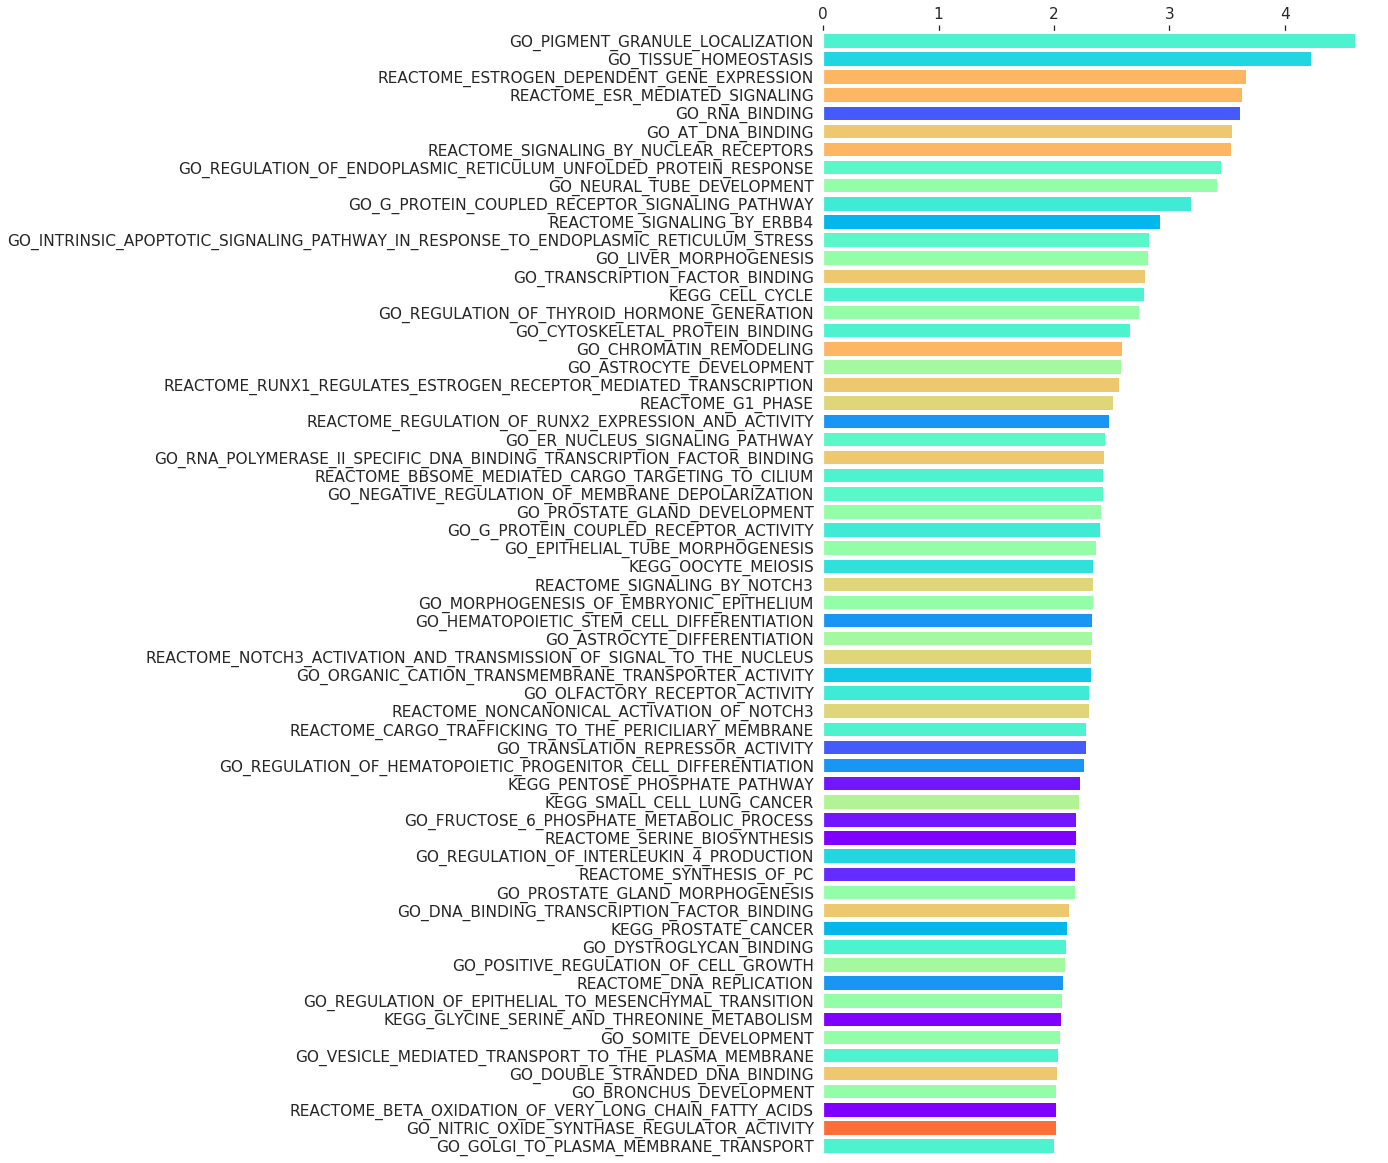

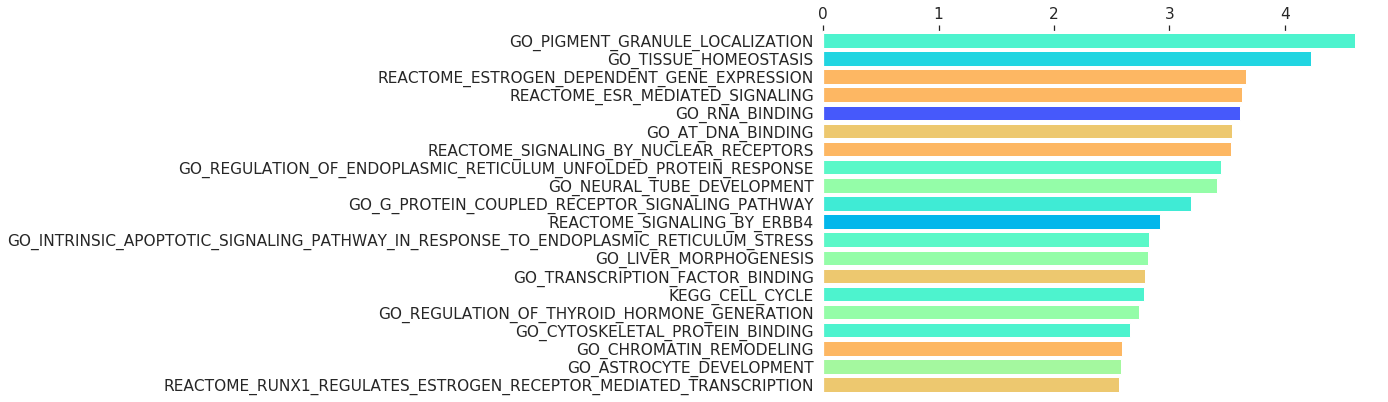

In [35]:
ax = static_enrichment_bar_plot(toplot_data,np.sum(toplot_data["edge_weights"]>-np.log10(.01)))
ax = static_enrichment_bar_plot(toplot_data,20)

In [36]:
for i,elt in enumerate([x.get_text() for x in list(ax.get_yticklabels())]):
    pway_name_str_split = elt.split("_")
    pway_name_str_split = [x.lower() for x in pway_name_str_split]
    pway_name_str_split[0] = pway_name_str_split[0].upper()
    print("%s (%i)-%i"%(" ".join(pway_name_str_split), coms[np.where(pathway_names==elt)[0][0]]+1, i+1))

GO pigment granule localization (15)-1
GO tissue homeostasis (12)-2
REACTOME estrogen dependent gene expression (27)-3
REACTOME esr mediated signaling (27)-4
GO rna binding (5)-5
GO at dna binding (26)-6
REACTOME signaling by nuclear receptors (27)-7
GO regulation of endoplasmic reticulum unfolded protein response (16)-8
GO neural tube development (20)-9
GO g protein coupled receptor signaling pathway (14)-10
REACTOME signaling by erbb4 (10)-11
GO intrinsic apoptotic signaling pathway in response to endoplasmic reticulum stress (16)-12
GO liver morphogenesis (20)-13
GO transcription factor binding (26)-14
KEGG cell cycle (15)-15
GO regulation of thyroid hormone generation (20)-16
GO cytoskeletal protein binding (15)-17
GO chromatin remodeling (27)-18
GO astrocyte development (21)-19
REACTOME runx1 regulates estrogen receptor mediated transcription (26)-20


In [37]:
fig = interactive_mod_change_bar_plot(mod_change_df)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500)

fig.show()

In [38]:
for com in mod_change_df.iloc[:6]["com"]:
    print(com)
    for elt in get_top_kmers(com,2):
        print(elt)

20.0
GROWTH FACTOR BETA
TRANSFORMING GROWTH FACTOR
1.0
OXIDOREDUCTASE ACTIVITY ACTING
ACTIVITY ACTING CH
26.0
TRANSCRIPTION FACTOR BINDING
RNA POLYMERASE II
15.0
REGULATION CELL CYCLE
TP53 REGULATES TRANSCRIPTION
16.0
APOPTOTIC SIGNALING PATHWAY
TP53 REGULATES TRANSCRIPTION
3.0
ACYL CHAIN REMODELLING
COA LIGASE ACTIVITY


In [39]:
fig2 = interactive_enrichment_strip_plot(toplot_data, top_num, 0)
fig2.show()

In [40]:
to_plot_df_nodes = toplot_data[toplot_data["edge_weights"]>-np.log10(.05)].sort_values("edge_weights", ascending=False)[:20].index
    

In [41]:

barchart_order = [x.get_text() for x in list(ax.get_yticklabels())]
num_plot = np.sum(toplot_data["edge_weights"]>-np.log10(.02))
fig, nodes_shown, sig_thresh_in_graph = update_network_graph(toplot_data, num_plot, barchart_order, maxwidth = 8, minwidth = .7, maxnodesize = 40, minnodesize = 15, spring_k=2)

fig.update_layout(
    autosize=False,
    width=1000,
    height=500)
fig.show()

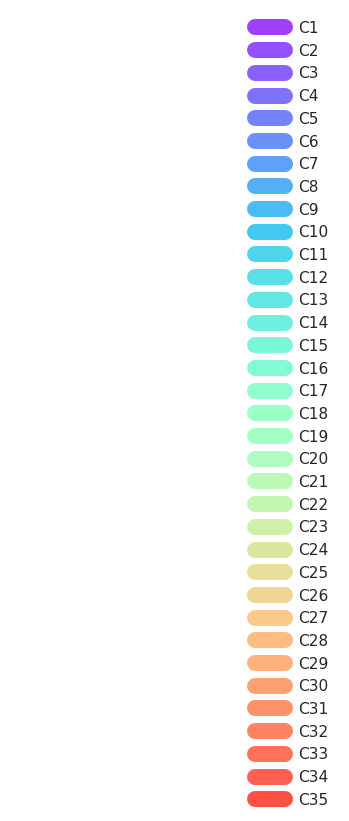

In [42]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c,alpha=.75,  lw=16) for c in list(C_colormap.values())+["#eeeeee"]]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(C_colormap.keys()) + 1)/12))
num_cols=1
ax.legend(custom_lines,  list(C_colormap.keys()), frameon=False, ncol=num_cols)
plt.show() 